# Lecture 2: Rayleigh fractionation

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
# import the vapor pressure formulas by Murphy&Koop 2005 doi:10.1256/qj.04.94
from typhon.physics import e_eq_ice_mk,e_eq_water_mk


In [4]:
#%% fractionation factor empirical equations
# for a nice summary of different fractionation factors, see also: https://www.cambridge.org/core/journals/journal-of-glaciology/article/numerical-experiments-on-firn-isotope-diffusion-with-the-community-firn-model/AD8B85B8BCE7F0DB073CC1ABFFD2CB17
def alphaD_Ell(T):
    ''' fractionation factor for Deuterium alpha_ice/vapour (Ellehoj 2013) for Temp -40 - 0°C,
    input Temperature in C:'''
    # for alpha_vapour/ice simply 1/alphaD
    if np.any(T>0):
        print('ERROR alpha: T='+str(np.round(T,2))+' above 0 °C')    
    TK=T+273.15
    alphaD=np.exp(0.2133-(203.1/TK)+(48888/(TK**2)))
    return alphaD

def alphaD_MN(T):
    ''' fractionation factor for Deuterium alpha_ice/vapour (Merlivat & Nief 1967)
    -40°C bis 0°C, input Temperature in °C:'''
    if np.any(T>0):
        print('ERROR alpha: T='+str(np.round(T,2))+' above 0 °C')    
    # for alpha_vapour/ice simply 1/alphaD
    TK=T+273.15
    #log alphaD=-4.1*1e-2+(7.074/(T**2)) #the original in the paper using log(10)
    alphaD=np.exp(-9.45*1e-2+(16.289*1e3/(TK**2))) #also given in MN paper on page 125
    return alphaD

def alpha18O_Ell(T):
    ''' fractionation coefficient for 18O alpha_ice/vapour (Ellehoj 2013) for Temp -40 - 0°C
    input Temperature in C:'''
    # for alpha_vapour/ice simply 1/alpha18O
    if np.any(T>0):
        print('ERROR alpha: T='+str(np.round(T,2))+' above 0 °C')
    TK=T+273.15
    alpha18O=np.exp(0.0831-(49.192/TK)+(8312.5/(TK**2)))
    return alpha18O

def alpha18O_Maj(T):
    ''' fractionation coefficient for 18O alpha_ice/vapour (Majoube 1971b):
    from 0°C- -33.4°C,  Temp in K'''
    if np.any(T>0):
        print('ERROR alpha: T='+str(np.round(T,2))+' above 0 °C')
    #T in K 
    # for alpha_vapour/ice simply 1/alpha18O
    TK=T+273.15
    alpha18O=np.exp((11.839/TK)-28.224*1e-3)
    return alpha18O

def alpha18O_Maj_Tpos(T):
    ''' fractionation coefficient for 18O alpha_liquid/vapour (Majoube 1971a):
    from 0°C- 100°C,  Temp in K'''
    if np.any(T<0):
        print('ERROR alpha: T='+str(np.round(T,2))+' below 0 °C')
    #T in K 
    # for alpha_vapour/liquid simply 1/alpha18O
    TK=T+273.15
    alpha18O=np.exp((1137/(TK**2))-(0.4156/TK)-2.0667*1e-3)
    return alpha18O

def alphaD_Maj_Tpos(T):
    ''' fractionation coefficient for D alpha_liquid/vapour (Majoube 1971a):
    from 0°C- 100°C,  Temp in K'''
    if np.any(T<0):
        print('ERROR alpha: T='+str(np.round(T,2))+' below 0 °C')
    #T in K 
    # for alpha_vapour/liquid simply 1/alpha18O
    TK=T+273.15
    alphaD=np.exp((24844/TK**2)-(76.248/TK)+52.612*1e-3)
    return alphaD


# useful functions to turn R into delta and vice versa
def R18todelta(R):
    RVSMOW_18O=2005.2*1e-6 #+- 0.45
    return (R/RVSMOW_18O-1)*1000
    
def RDtodelta(R):
    RVSMOW_D=155.76*1e-6   # +-0.05 
    return (R/RVSMOW_D-1)*1000

def delta18toR(delta):
    RVSMOW_18O=2005.2*1e-6 #+- 0.45
    return (delta/1000+1)*RVSMOW_18O
    
def deltaDtoR(delta):
    RVSMOW_D=155.76*1e-6   # +-0.05 
    return (delta/1000+1)*RVSMOW_D

__The Rayleigh fractionation function__

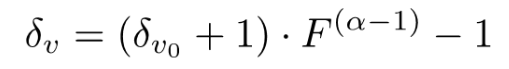
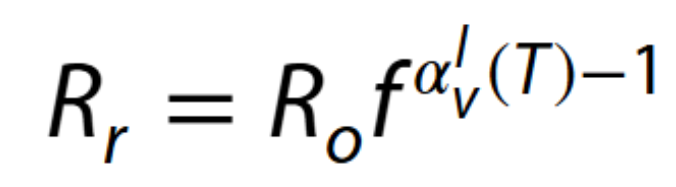

- R0, and delta_v0 are the initial vapor isotopic compositions
- F or f is the fraction of remaining vapor
- alpha is the temperature dependent fractionation coefficient, think about which definition to use
- T is Temperature of the air mass



In [59]:
# functions for the Rayleigh fractionation model 
def rayleigh18O(T,delta18s0):    
    '''T is vector of temperatures (in C) with first entry being the intitial condition temperature, and subsequently decreasing temperatures
    delta18sO is initial ocean isotopic composition from which initial vapor isotopic composition is calculated at T0'''
    T0=T[0]
    #
    
    # remaining vapor fraction above zero
    maskpos=T>=0
    Psat0w=e_eq_water_mk(T0+273.15) # input in Kelvin
    Psatw=e_eq_water_mk(T[maskpos]+273.15)#
    fpos=Psatw/Psat0w # the ratio of remaining vapor fraction

    if np.any(T)<0:
        # remaining vapor fraction below zero
        maskneg=T<0
        Psat0ice=e_eq_ice_mk(T[maskneg][0]+273.15)
        Psatice=e_eq_ice_mk(T[maskneg]+273.15)
        fneg=Psatice/Psat0ice
        fnegplot=Psatice/Psat0ice*fpos[-1]
        
        ftotal=np.append(fpos,fnegplot[1:])
    else:
        ftotal=fpos        
    
    #initial vapor isotopic composition at temperature T0
    delta18v0=R18todelta(1/alpha18O_Maj_Tpos(T0)*delta18toR(delta18s0))
    
    delta18v0=delta18v0/1000

    # deltav positive temperatures
    delta18vpos=((delta18v0+1)*(fpos)**(alpha18O_Maj_Tpos(T[maskpos])-1)-1)*1000
    # the condensate isotopic composition
    delta18spos = (alpha18O_Maj_Tpos(T[maskpos])*(delta18vpos/1000+1)-1)*1000

    if np.any(T)<0:
        # vapor negative temp
        delta18v0neg=delta18vpos[-1]/1000
        delta18vneg=((delta18v0neg+1)*(fneg)**(alpha18O_Maj(T[maskneg])-1)-1)*1000
        # the condensate isotopic composition
        delta18sneg = (alpha18O_Maj(T[maskneg])*(delta18vneg/1000+1)-1)*1000
        # concatenate the vectors
        delta18vtotal=np.append(delta18vpos[:-1],delta18vneg)
        delta18stotal=np.append(delta18spos[:-1],delta18sneg)
    else:
        delta18vtotal=delta18vpos
        delta18stotal=delta18spos    
    
    return delta18vtotal,delta18stotal,ftotal


def rayleighD(T,deltaDs0):    
    '''T is vector of temperatures (in C) with first entry being the intitial condition temperature
    deltaDsO is initial ocean isotopic composition from which initial vapor isotopic composition is calculated at T0'''
    T0=T[0]
    #
    
    # remaining vapor fraction above zero
    maskpos=T>=0
    Psat0w=e_eq_water_mk(T0+273.15) # input in Kelvin
    Psatw=e_eq_water_mk(T[maskpos]+273.15)#
    fpos=Psatw/Psat0w # the ratio of remaining vapor fraction

    if np.any(T)<0:
        # remaining vapor fraction below zero
        maskneg=T<0
        Psat0ice=e_eq_ice_mk(T[maskneg][0]+273.15)
        Psatice=e_eq_ice_mk(T[maskneg]+273.15)
        fneg=Psatice/Psat0ice
        fnegplot=Psatice/Psat0ice*fpos[-1]
        
        ftotal=np.append(fpos,fnegplot[1:])
    else:
        ftotal=fpos
    
    #initial vapor isotopic composition at Temp T0
    deltaDv0=RDtodelta(1/alphaD_Maj_Tpos(T0)*deltaDtoR(deltaDs0))
    
    # delta v positive temperatures
    deltaDv0=deltaDv0/1000
    deltaDvpos=((deltaDv0+1)*(fpos)**(alphaD_Maj_Tpos(T[maskpos])-1)-1)*1000
    # the condensation isotopic composition at each step
    deltaDspos = (alphaD_Maj_Tpos(T[maskpos])*(deltaDvpos/1000+1)-1)*1000

    if np.any(T)<0:
        # vapor negative temp
        deltaDv0neg=deltaDvpos[-1]/1000
        deltaDvneg=((deltaDv0neg+1)*(fneg)**(alphaD_MN(T[maskneg])-1)-1)*1000
        # the condensation isotopic composition at each step
        deltaDsneg = (alphaD_MN(T[maskneg])*(deltaDvneg/1000+1)-1)*1000
        
        deltaDvtotal=np.append(deltaDvpos[:-1],deltaDvneg)
        deltaDstotal=np.append(deltaDspos[:-1],deltaDsneg)
    else:
        deltaDvtotal=deltaDvpos
        deltaDstotal=deltaDspos
    return deltaDvtotal,deltaDstotal,ftotal

In [61]:
# calculate the Rayleigh distillation model
Tvec=np.flip(np.arange(0.5,30,0.5))
delta18vtotal,delta18stotal,ftotal=rayleigh18O(Tvec,delta18s0=0)


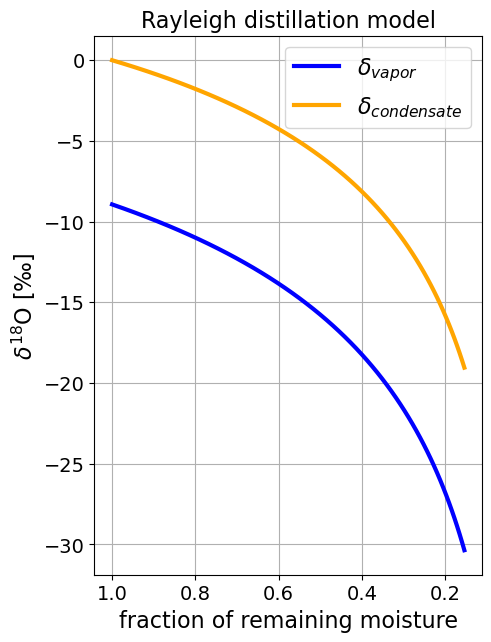

In [63]:
# make plot for lecture




fig,ax=plt.subplots(1,1,figsize=(5,7))
ax.plot(ftotal,delta18vtotal,color='blue',lw=3,label=r'$\delta_{vapor}$')
ax.plot(ftotal,delta18stotal,color='orange',ls='-',lw=3,label=r'$\delta_{condensate}$')
ax.invert_xaxis()
ax.set_xlabel('fraction of remaining moisture', fontsize=16)
ax.set_ylabel(r'$\delta^{18}$O [‰]', fontsize=16)
ax.tick_params(axis='both', labelsize=14)
ax.legend(fontsize=16)
ax.set_title('Rayleigh distillation model', fontsize=16)
ax.grid()
plt.show()
fig.tight_layout()
fig.savefig('RayleighVaporCondensate.png')


In [23]:
delta=-35
delta18toR(delta)

0.001935018

In [27]:
# alpha_liquid/vapour
R18todelta(alpha18O_Maj_Tpos(12)*delta18toR(-40))



-29.906424971427036

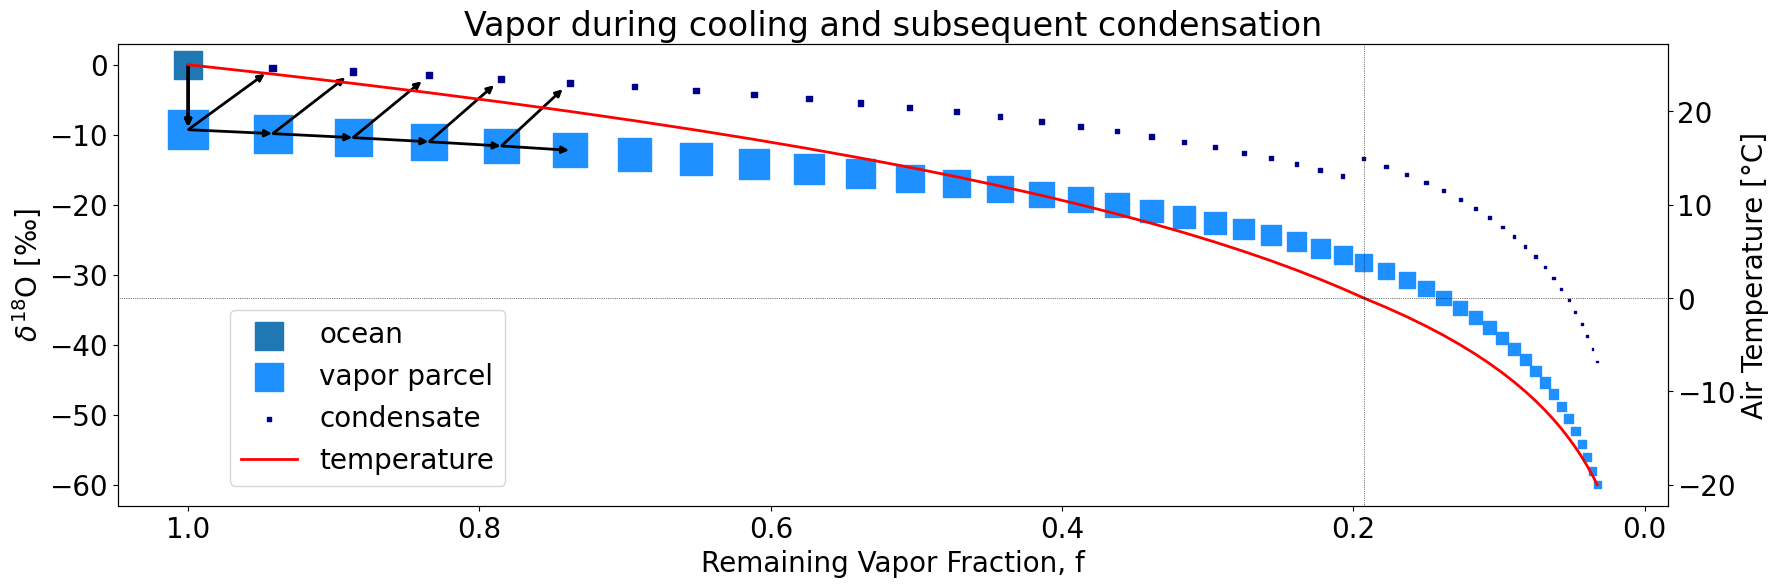

In [60]:
Ttest=np.flip(np.arange(-20.,26.,1))
delta18vtest,delta18stest,ftest=rayleigh18O(Ttest,delta18s0=0)

fig,ax1=plt.subplots(1,1,figsize=(20,6))
ax2=ax1.twinx()
a0=ax1.scatter(ftest[0],0,marker='s',s=400,label='ocean')
a1=ax1.scatter(ftest,delta18vtest,s=ftest*800,marker='s',color='dodgerblue',label='vapor parcel')
a2=ax1.scatter(ftest[1:],delta18stest[1:],s=(ftest[:-1]-ftest[1:])*400,marker='s',color='darkblue',label='condensate')
ax1.invert_xaxis()
a3=ax2.plot(ftest,Ttest,c='r',lw=2,label='temperature')
ax2.axhline(ls=':',lw=0.5,c='k')
ax2.axvline(ftest[np.where(Ttest==0)],ls=':',lw=0.5,c='k')
ax1.set_xlabel('Remaining Vapor Fraction, f',fontsize=20)
ax1.set_ylabel(r'$\delta^{18}$O [‰]',fontsize=20)
ax2.set_ylabel('Air Temperature [°C]',fontsize=20)
ax1.tick_params(axis='both', labelsize=20)
ax2.tick_params(axis='both', labelsize=20)

for i in np.arange(0,len(ftest[0:5])):
    ax1.annotate("",xy=(ftest[i+1], delta18stest[i+1]), xycoords='data',
                xytext=(ftest[i], delta18vtest[i]), textcoords='data',
                arrowprops=dict(arrowstyle="-|>", lw=2,color='k',shrinkA=0.5,shrinkB=7))
    ax1.annotate("",xy=(ftest[i+1], delta18vtest[i+1]), xycoords='data',
                xytext=(ftest[i], delta18vtest[i]), textcoords='data',
                arrowprops=dict(arrowstyle="-|>", lw=2,connectionstyle="arc3",color='k',shrinkA=0.5,shrinkB=0.5),)
    
    
    ax1.annotate("",xy=(ftest[0], delta18vtest[1]), xycoords='data',
                xytext=(ftest[0], delta18stest[0]), textcoords='data',
                arrowprops=dict(arrowstyle="-|>", lw=2,color='k',connectionstyle="arc3",shrinkA=0.5,shrinkB=5))

ax1.set_title('Vapor during cooling and subsequent condensation',fontsize=24)
fig.legend(fontsize=20,bbox_to_anchor=[0.25, 0.29], loc='center',  bbox_transform=fig.transFigure,frameon=True)


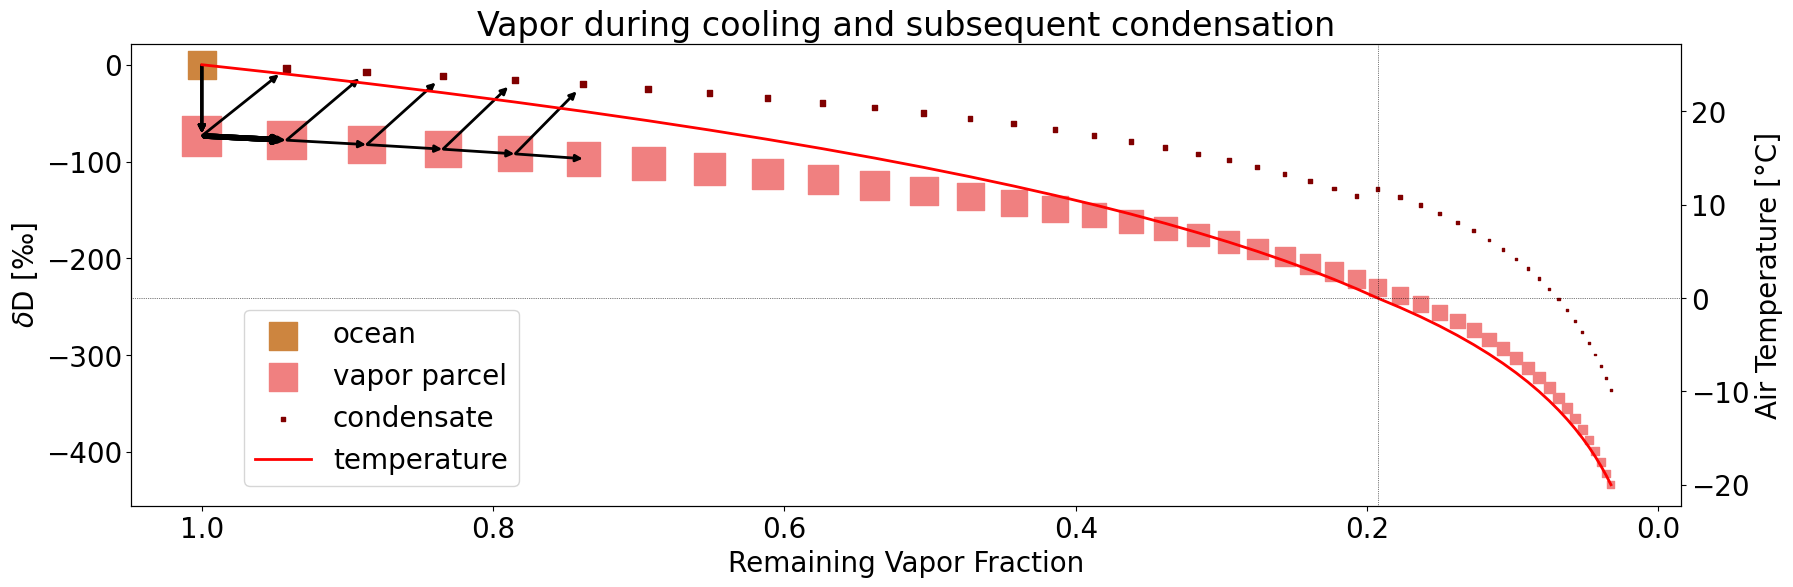

In [62]:
Ttest=np.flip(np.arange(-20.,26.,1))
deltaDvtest,deltaDstest,ftest=rayleighD(Ttest,deltaDs0=0)

fig,ax1=plt.subplots(1,1,figsize=(20,6))
ax2=ax1.twinx()
a0=ax1.scatter(ftest[0],0,marker='s',s=400,label='ocean',color='peru')
a1=ax1.scatter(ftest,deltaDvtest,s=ftest*800,marker='s',color='lightcoral',label='vapor parcel')
a2=ax1.scatter(ftest[1:],deltaDstest[1:],s=(ftest[:-1]-ftest[1:])*400,marker='s',color='maroon',label='condensate')
ax1.invert_xaxis()
a3=ax2.plot(ftest,Ttest,c='r',lw=2,label='temperature')
ax2.axhline(ls=':',lw=0.5,c='k')
ax2.axvline(ftest[np.where(Ttest==0)],ls=':',lw=0.5,c='k')
ax1.set_xlabel('Remaining Vapor Fraction',fontsize=20)
ax1.set_ylabel(r'$\delta$D [‰]',fontsize=20)
ax2.set_ylabel('Air Temperature [°C]',fontsize=20)
ax1.tick_params(axis='both', labelsize=20)
ax2.tick_params(axis='both', labelsize=20)

for i in np.arange(0,len(ftest[0:5])):
    ax1.annotate("",xy=(ftest[i+1], deltaDstest[i+1]), xycoords='data',
                xytext=(ftest[i], deltaDvtest[i]), textcoords='data',
                arrowprops=dict(arrowstyle="-|>", lw=2,color='k',shrinkA=0.5,shrinkB=7))
    ax1.annotate("",xy=(ftest[i+1], deltaDvtest[i+1]), xycoords='data',
                xytext=(ftest[i], deltaDvtest[i]), textcoords='data',
                arrowprops=dict(arrowstyle="-|>", lw=2,connectionstyle="arc3",color='k',shrinkA=0.5,shrinkB=0.5),)
    
    
    ax1.annotate("",xy=(ftest[0], deltaDvtest[1]), xycoords='data',
                xytext=(ftest[0], deltaDstest[0]), textcoords='data',
                arrowprops=dict(arrowstyle="-|>", lw=2,color='k',connectionstyle="arc3",shrinkA=0.5,shrinkB=5))
    ax1.annotate("",xy=(ftest[1], deltaDvtest[1]), xycoords='data',
                xytext=(ftest[0], deltaDvtest[0]), textcoords='data',
                arrowprops=dict(arrowstyle="->", lw=4,connectionstyle="arc3"),)

ax1.set_title('Vapor during cooling and subsequent condensation',fontsize=24)
fig.legend(fontsize=20,bbox_to_anchor=[0.25, 0.29], loc='center',  bbox_transform=fig.transFigure,frameon=True)#facecolor='white',framealpha=1)
#fig.savefig('path_to_file.png',dpi=150) # use this if you want to save the figure as png

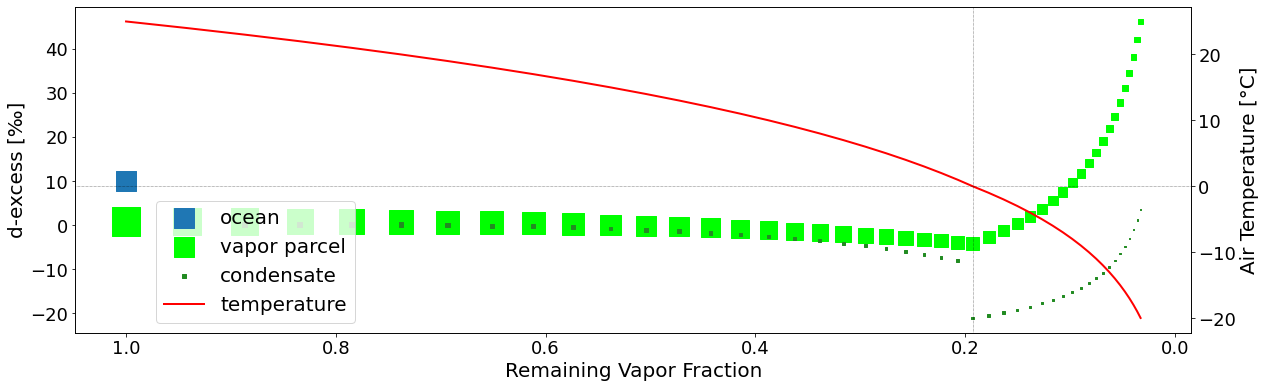

In [26]:
# plot d-excess of this rayleigh fractionation
# THIS IS IN AGREEEMTN WITH FIGURE 6 IN JOUZEL&MERLIVAT 1983!‚

dexvtest=deltaDvtest-8*delta18vtest
dexstest=deltaDstest-8*delta18stest

Ttest=np.flip(np.arange(-20.,26.,1))

fig,ax1,ax2=plot1(figsize=(20,6))
a0=ax1.scatter(ftest[0],10,marker='s',s=400,label='ocean')
a1=ax1.scatter(ftest,dexvtest,s=ftest*800,marker='s',color='lime',label='vapor parcel')
a2=ax1.scatter(ftest[1:],dexstest[1:],s=(ftest[:-1]-ftest[1:])*400,marker='s',color='forestgreen',label='condensate')
ax1.invert_xaxis()
a3=ax2.plot(ftest,Ttest,c='r',lw=2,label='temperature')
ax2.axhline(ls=':',lw=0.5,c='k')
ax2.axvline(ftest[np.where(Ttest==0)],ls=':',lw=0.5,c='k')
ax1.set_xlabel('Remaining Vapor Fraction',fontsize=20)
ax1.set_ylabel(r'd-excess [‰]',fontsize=20)
ax2.set_ylabel('Air Temperature [°C]',fontsize=20)

#
#for i in np.arange(0,len(ftest[0:5])):
#    ax1.annotate("",xy=(ftest[i+1], delta18stest[i+1]), xycoords='data',
#                xytext=(ftest[i], delta18vtest[i]), textcoords='data',
#                arrowprops=dict(arrowstyle="-|>", lw=2,color='k',shrinkA=0.5,shrinkB=7))
#    ax1.annotate("",xy=(ftest[i+1], delta18vtest[i+1]), xycoords='data',
#                xytext=(ftest[i], delta18vtest[i]), textcoords='data',
#                arrowprops=dict(arrowstyle="-|>", lw=2,connectionstyle="arc3",color='k',shrinkA=0.5,shrinkB=0.5),)
#    
#    
#    ax1.annotate("",xy=(ftest[0], delta18vtest[1]), xycoords='data',
#                xytext=(ftest[0], delta18stest[0]), textcoords='data',
#                arrowprops=dict(arrowstyle="-|>", lw=2,color='k',connectionstyle="arc3",shrinkA=0.5,shrinkB=5))
#    ax1.annotate("",xy=(ftest[1], delta18vtest[1]), xycoords='data',
#                xytext=(ftest[0], delta18vtest[0]), textcoords='data',
#                arrowprops=dict(arrowstyle="->", lw=4,connectionstyle="arc3"),)
#

# added these three lines
#lns = [a0,a1,a2,a3]
#labs = [l.get_label() for l in lns]
#fig.legend(lns, labs,fontsize=20,bbox_to_anchor=[0.25, 0.25], loc='center',  bbox_transform=fig.transFigure,frameon=True)

fig.legend(fontsize=20,bbox_to_anchor=[0.25, 0.29], loc='center',  bbox_transform=fig.transFigure,frameon=True)#facecolor='white',framealpha=1)
#fig.savefig('/Users/sonjaw/Documents/UiB/Thesis_SW/thesis_figures_exchange/rayleigh_scheme_dexcess.png',dpi=150)
fig.savefig('/Users/sonjaw/Documents/UiB/SnowDOGS/SnowDOGS_travel/China2025/plots_Chinalectures/rayleigh_scheme_dexcess.png',dpi=150)


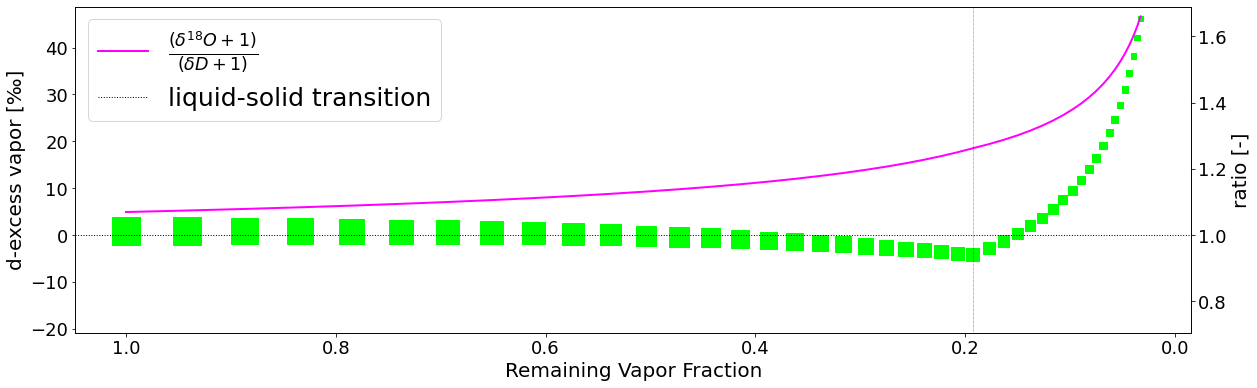

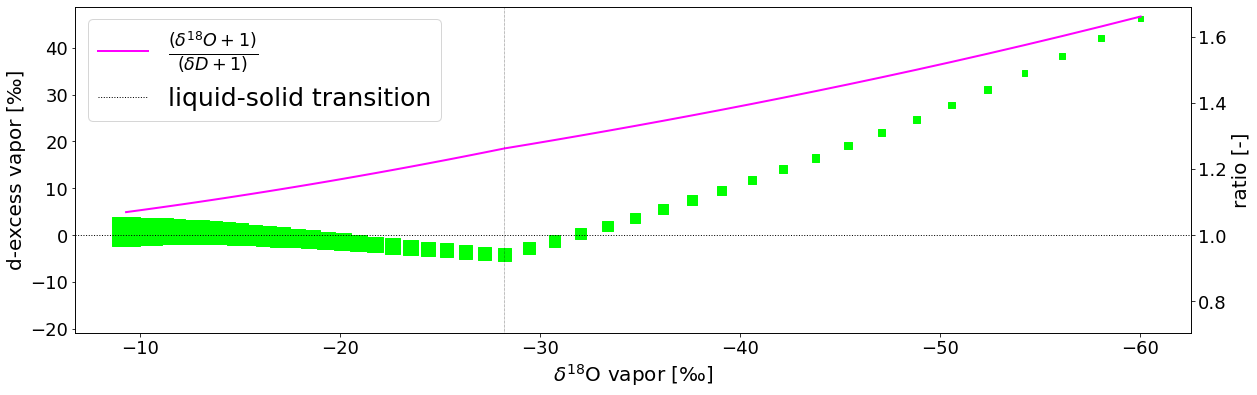

In [41]:
# Make the delta-scale effect visisble that Marina Dütsch mentions in her paper:

import mpl_axes_aligner.align as align
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)


dexvtest=deltaDvtest-8*delta18vtest
#dexstest=deltaDstest-8*delta18stest
ratio=(delta18vtest/1000+1)/(deltaDvtest/1000+1)

#Ttest=np.flip(np.arange(-20.,26.,1))

# vs temperature

fig,ax1,ax2=plot1(figsize=(20,6))
#a0=ax1.scatter(ftest[0],10,marker='s',s=400,label='ocean')
a1=ax1.scatter(ftest,dexvtest,s=ftest*800,marker='s',color='lime',label='vapor parcel')
#a2=ax1.scatter(ftest[1:],dexstest[1:],s=(ftest[:-1]-ftest[1:])*400,marker='s',color='forestgreen',label='condensate')

ax1.invert_xaxis()
a3=ax2.plot(ftest,ratio,c='magenta',lw=2,label=r'$\frac{(\delta^{18}O+1)}{(\delta D+1)}$')

ax2.axvline(ftest[np.where(Ttest==0)],ls=':',lw=0.5,c='k')
ax1.set_xlabel('Remaining Vapor Fraction',fontsize=20)
ax1.set_ylabel(r'd-excess vapor [‰]',fontsize=20)
ax2.set_ylabel('ratio [-]',fontsize=20)
# Adjust the plotting range of two y axes
org1 = 0.0  # Origin of first axis
org2 = 1.0  # Origin of second axis
pos = 0.3  # Position the two origins are aligned
align.yaxes(ax1, org1, ax2, org2, pos)
ax2.axhline(1,ls=':',lw=1,c='k',label='liquid-solid transition')
ax2.legend(fontsize=25)
fig.savefig('/Users/sonjaw/Documents/UiB/SnowDOGS/SnowDOGS_travel/China2025/plots_Chinalectures/delta_scale_effect_remainingvapor.png',dpi=150)




# vs depletion
fig,ax1,ax2=plot1(figsize=(20,6))
#a0=ax1.scatter(ftest[0],10,marker='s',s=400,label='ocean')
a1=ax1.scatter(delta18vtest,dexvtest,s=ftest*800,marker='s',color='lime',label='vapor parcel')
#a2=ax1.scatter(ftest[1:],dexstest[1:],s=(ftest[:-1]-ftest[1:])*400,marker='s',color='forestgreen',label='condensate')

ax1.invert_xaxis()
a3=ax2.plot(delta18vtest,ratio,c='magenta',lw=2,label=r'$\frac{(\delta^{18}O+1)}{(\delta D+1)}$')

ax2.axvline(delta18vtest[np.where(Ttest==0)],ls=':',lw=0.5,c='k')
#ax1.set_xlabel('Remaining Vapor Fraction',fontsize=20)
ax1.set_xlabel(r'$\delta^{18}$O vapor [‰]',fontsize=20)
ax1.set_ylabel(r'd-excess vapor [‰]',fontsize=20)
ax2.set_ylabel('ratio [-]',fontsize=20)
# Adjust the plotting range of two y axes
org1 = 0.0  # Origin of first axis
org2 = 1.0  # Origin of second axis
pos = 0.3  # Position the two origins are aligned
align.yaxes(ax1, org1, ax2, org2, pos)
ax2.axhline(1,ls=':',lw=1,c='k',label='liquid-solid transition')
ax2.legend(fontsize=25)
fig.savefig('/Users/sonjaw/Documents/UiB/SnowDOGS/SnowDOGS_travel/China2025/plots_Chinalectures/delta_scale_effect.png',dpi=150)




In [45]:
print(delta18vtest[np.where(np.round(ftest,1)==0.1)])
print(delta18stest[np.where(np.round(ftest,1)==0.1)])

[-33.36092105 -34.7354086  -36.14597819 -37.59321338 -39.07770521
 -40.60005224 -42.16086051 -43.7607436  -45.40032259 -47.08022612
 -48.80109029 -50.56355872]
[-18.00343298 -19.23888942 -20.5102421  -21.81809358 -23.16305457
 -24.54574397 -25.96678889 -27.42682467 -28.92649493 -30.46645153
 -32.04735467 -33.66987279]


In [ ]:
## Rayleigh for Deuterium
function [ deltaD ] = rayleighD( T, deltaD0, f)


alphaD_lv=exp((0.052612-76.248/(T+273.15)+24844/(T+273.15)^2));
alphaD_vl=1/alphaD_lv;
# aD=exp((0.052612-76.248/(T+273.15)+24844/(T+273.15)^2))
# alpha_D_liquid = exp((52.612 - 76.248*(1000./self.T) + 24.844*(1e6/self.T**2))/1000)

RD0=deltaD0/1000;

deltaD =((RD0+1)*(f).^(alphaD_vl-1)-1)*1000;

end

In [ ]:
## Rayleigh fractionation for O18
function [ delta18 ] = rayleigh18( T, delta180,f)


alpha18_vl=exp((-1137/(T+273.15)^2)+0.4156/(T+273.15)+0.0020667);
%alpha_o18_liquid = exp((-2.0667 - 0.4156*(1e3/(T+273.15)) + 1.137*(1e6/(T+273.15)^2))/1000)

delta180=delta180/1000;

delta18 =((delta180+1)*(f).^(alpha18_vl-1)-1)*1000;

end

In [ ]:
# Rayleigh fractionation matlab script
# Script calculating a one step Rayleigh fractionation from temperature
# T1 and pressure P1 to temperature T2 and pressure P2.

# This script can be used to solve exercises 2 and 3 in notes on isotopes.

T1=16;             # Input initial temperature in deg C
T2=14;             # Input final temperature in deg C
P1=1013;            # Input initial air pressure in hPa
P2=1013;            # Input final air pressure in hPa
dD0=-230;           # Input d18O (in per mil) of initial vapor
d180=-10;           # Input dD (in per mil) of initial vapor

d180=d180/1000;
dD0=dD0/1000;

c=1.025;      # Constant used for calculation of the supersaturation ratio
FS=0.006;     # Constant for calculation of the supersaturation ratio
dif2=1.0285;  # Ratio between diffusion constant in air for H2O and HDO
dif18=1.0251; # Ratio between diffusion constant in air for H2O16 and H2O18
T=(T1+T2)/2;  # Average temperature for fractionation calculations

# Calculation of fractionation factors and water vapor mixing ratios for
# equilibrium (T>=0) and non-equilibrium conditions (T<0)

if T>=0              
    a18=exp((-0.00207-0.4156/(T+273.15)+1137/(T+273.15)^2)) #alpha_lv
    aD=exp((0.052612-76.248/(T+273.15)+24844/(T+273.15)^2)) #alpha_lv
    WSat1=(1.56871e9/P1)*exp(-5418.7/(T1+273.15))
    WSat2=(1.56871e9/P2)*exp(-5418.7/(T2+273.15))
    ak18=1;  # Equlibrium, so no kinetic effects
    akD=1;   # Equlibrium, so no kinetic effects
else
    a18=0.9722*exp(11.839/(T+273.15))
    aD=0.9098*exp(16289/((T+273.15)^2))
    S=c-FS*T;
    ak18=S/(1+a18*(S-1)*dif18)  # Non-equilibrium, so kinetic effects
    akD=S/(1+aD*(S-1)*dif2)     # Non-equilibrium, so kinetic effects
    WSat1=(22.1026e9/P1)*exp(-6141.4/(T1+273.15))
    WSat2=(22.1026e9/P2)*exp(-6141.4/(T2+273.15))
end

#Rayleigh fractionation calculation of delta values in remaining vapour
d18v=((d180+1)*((WSat2/WSat1)^((a18*ak18)-1))-1)*1000
dDv=((dD0+1)*((WSat2/WSat1)^((aD*akD)-1))-1)*1000
dv=dDv-8*d18v

# Rayleigh fractionation calculation of delta values in condensate
#simply alpha times R_v
d18c=((a18*ak18)*(d180+1)*((WSat2/WSat1)^((a18*ak18)-1))-1)*1000
dDc=((aD*akD)*(dD0+1)*((WSat2/WSat1)^((aD*akD)-1))-1)*1000
dc=dDc-8*d18c

In [ ]:

## fractionation experiment in class


# Greenland water was heated and mass measured before(N0) and after
# evaporation(N)
m=load('FractionationExp_results.txt');
N0=m(:,3)-m(:,2);
N=m(:,4)-m(:,2);
N_N0=N./N0;
deltaD_data=m(:,6);
delta18O_data=m(:,5);

# figure()
# yyaxis left
# plot(N_N0,deltaD,'*b')
# ylabel('per mill')
# hold on
# yyaxis right
# plot(N_N0,delta18o,'or')
# xlabel('N/N0')
# ylabel('per mill')
# legend('delta^D','delta^1^8 O')

f=[0.01:0.01:1];   #fraction of remaining mass..
delta18=rayleigh18(25,-40,f);
deltaD=rayleighD(25,-325,f);




figure()
subplot(2,1,1)
plot(N_N0,deltaD_data,'*b')
hold on
plot(f,deltaD,'g')
#set(gca,'Xdir','reverse')
legend('delta^D','self','fit')
subplot(2,1,2)
plot(N_N0,delta18O_data,'or')
hold on
plot(f,delta18)
set(gca,'Xdir','reverse')
legend('delta^1^8 O','self','fit')


##



xdata=N_N0(2:end);  #fraction of remaining water
y=deltaD_data(2:end);
delta_D0=-325;
#xdata=[0.01:0.01:1];
# axis([0 2 -0.5 6])
# hold on
figure()
plot(xdata,y,'ro')
#set(gca,'Xdir','reverse')
title('Data points')
# hold off

#find the best fractinoatino factor that miminised the fit..

# --> this is what I could do for finding the effective fractionatino
# factor

F=@(x,xdata)((delta_D0+1)*xdata.^(x(1)-1)-1)*1000;
x0 = [0.9];
lb = [0.9];
ub = [0.99999999];
[x,resnorm,~,exitflag,output] = lsqcurvefit(F,x0,xdata,y,lb,ub)
#x = lsqcurvefit(F,x0,xdata,y)
hold on
plot(xdata,F(x,xdata))
hold off

# t = Data(:,1);
# y = Data(:,2);
# # axis([0 2 -0.5 6])
# # hold on
# figure()
# plot(t,y,'ro')
# title('Data points')
# # hold off
# 
# F = @(x,xdata)x(1)*exp(-x(2)*xdata) + x(3)*exp(-x(4)*xdata);
# x0 = [1 1 1 0];
# [x,resnorm,~,exitflag,output] = lsqcurvefit(F,x0,t,y)
# 
# hold on
# plot(t,F(x,t))
# hold off